In [1]:
from datasets import load_dataset, Dataset
import pandas as pd
ds = load_dataset("HuggingFaceH4/ultrafeedback_binarized", split="train_prefs")
def get_instruct_response(item):
    # item["instruction"] = item['chosen'][0]["content"]
    item["response"] = item['chosen'][1]["content"]
    return item
ds = ds.map(get_instruct_response, batch_size=1024, num_proc=8)
export_data = ds.select_columns(["prompt", "response"])
# export_data

/home/lidong1/miniconda3/envs/llama_factory/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from gpt4o import Openai, API_INFOS
oai_clients = Openai(
    apis=API_INFOS
)
res = oai_clients.get_response("对于LLM生成的文本，将其以markdown的格式进行渲染，从文本美学观感的角度看，对于文本美学观感比较重要的因素有哪些？")
from text2img import text_to_image
text_to_image(text=res, output_image="gpt4o.png")

In [ ]:
response_1 = export_data['response'][0]
response_10 = export_data['response'][9]
# print(response_10)
# response_10_html = markdown_to_html(response_10)
# with open("response_10_2.html", 'w') as f:
#     # f.write("\n")
#     f.write(response_10_html)

<!-- pandoc -f markdown -t html5 response10.md -o output.html -c github-pandoc.css
pandoc response10.md -o output.html -c style.css
pandoc -f markdown response10.md -o output.html -c github-pandoc.css
pandoc -s -c github-pandoc.css response10.md -o output2.html --self-contained
pandoc -s -c style2.css response10.md -o output10.html --self-contained
pandoc -s -c style.css response10.md -o output10.html --self-contained -->

In [ ]:
from text2img import text_to_image
for i in range(10):
    output_path = f"output_{i}.png"
    text = export_data["response"][i]
    text_to_image(text, output_path, size=(700, 1020))

In [ ]:
from text2img import text_to_image
output_path = "output.png"
text = response_10
text_to_image(text, output_path)

In [ ]:
def get_data():
    ds = load_dataset("HuggingFaceH4/ultrafeedback_binarized", split="train_prefs")
    def get_instruct_response(item):
        # item["instruction"] = item['chosen'][0]["content"]
        item["response"] = item['chosen'][1]["content"]
        return item
    ds = ds.map(get_instruct_response, batch_size=1024, num_proc=8)
    export_data = ds.select_columns(["prompt", "response"])
    return export_data

In [ ]:
# [{for item in ds['rejected'][0][1]['content']]
temp_data = data
# temp_ds = ds.select(range(10))
for i, item in enumerate(ds):
    # print(item['rejected'])
    # index=item['index']
    temp_data[i]['rejected'] = item['rejected'][1]['content']
    temp_data[i]['instruct'] = item['prompt']
temp_data

In [ ]:
from utils import read_jsonl
import json
data = read_jsonl("revised_data/output_sorted.jsonl")
not_revised = [item['index'] for item in data if item['revised_text'] == '']
# datalen
data
indices = set([item['index'] for item in data])
original_indices = set(range(export_data.shape[0]))
print(f"index complete: {original_indices - indices}")
null_response_indices = [item['index'] for item in data if item['gpt_answer'].strip() == '']
null_revised_indices = [item['index'] for item in data if item['revised_text'].strip() == '']
noneed_revised_indices = [item['index'] for item in data if item['does_it_need_modification'].strip() == 'N']
same_revised_text_indices = [item['index'] for item in data if item['response'].strip() == item['revised_text'].strip()]
# print(len(null_response))
# print(len(not_revised))
print(f"null_response_indices:{len(null_response_indices)}")
print(f"null_revised_indices:{len(null_revised_indices)}")
print(f"noneed_revised_indices:{len(noneed_revised_indices)}")
print(f"same_revised_text_indices:{len(same_revised_text_indices)}")
# 使用集合的交集操作  
indices_to_discard  = set(null_response_indices) | set(null_revised_indices) | set(noneed_revised_indices) | set(same_revised_text_indices)    
indices_to_discard = list(indices_to_discard)
print(f"indices_to_discard: {len(indices_to_discard)}")
temp_data = data
# temp_ds = ds.select(range(10))
for i, item in enumerate(ds):
    # print(item['rejected'])
    # index=item['index']
    temp_data[i]['rejected'] = item['rejected'][1]['content']
    temp_data[i]['instruct'] = item['prompt']
    temp_data[i]['chosen'] = item['chosen']
revised_data = [item for item in temp_data if item["index"] not in indices_to_discard]
print(f"length of revised data: {len(revised_data)}")
textual_aesthetics_chosen = [{"prompt": item["prompt"], "chosen": item["revised_text"], "rejected": item["response"]} for item in revised_data]
with open("/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_chosen.json", 'w') as f:
    json.dump(textual_aesthetics_chosen, f, indent=4)
textual_aesthetics_rejected = [{"prompt": item["prompt"], "chosen": item["revised_text"], "rejected": item["rejected"]} for item in revised_data]
with open("/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_rejected.json", 'w') as f:
    json.dump(textual_aesthetics_rejected, f, indent=4)

In [ ]:
print(textual_aesthetics_chosen[:3])
print(textual_aesthetics_rejected[:3])

In [ ]:
temp_data = data
# temp_ds = ds.select(range(10))
for i, item in enumerate(ds):
    # print(item['rejected'])
    # index=item['index']
    temp_data[i]['rejected'] = item['rejected'][1]['content']
    temp_data[i]['instruct'] = item['prompt']
    temp_data[i]['chosen'] = item['chosen']
# temp_data

In [ ]:
revised_data = [item for item in temp_data if item["index"] not in indices_to_discard]
revised_data

In [ ]:
revised_data = [item for item in data if item["index"] not in indices_to_discard]
revised_data_indices = [item['index'] for item in data if item["index"] not in indices_to_discard]
len(revised_data)

In [ ]:
textual_aesthetics_chosen = [{"prompt": item["prompt"], "chosen": item["revised_text"], "rejected": item["response"]} for item in revised_data]
import json
with open("/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_chosen.json", 'w') as f:
    json.dump(textual_aesthetics_chosen, f, indent=4)

In [ ]:
import json
with open("/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_chosen.json", 'w') as f:
    json.dump(textual_aesthetics_chosen, f, indent=4)

In [ ]:
same_revised_text_indices = [item['index'] for item in data if item['response'].strip() == item['revised_text'].strip()]
same_revised_text_indices

In [ ]:
data = read_jsonl("revised_data/output_retry.jsonl")
null_response = [item['index'] for item in data if item['gpt_answer'] == '']
not_revised = [item['revised_text'] for item in data if item['revised_text'] == '']
print(len(null_response))

In [ ]:
data = read_jsonl("revised_data/output_retry.jsonl")
null_response = [item['index'] for item in data if item['gpt_answer'] == '']
not_revised = [item['revised_text'] for item in data if item['revised_text'] == '']
print(len(null_response))

In [ ]:
def get_instruct_response(item):
    # item["instruction"] = item['chosen'][0]["content"]
    item["response"] = item['chosen'][1]["content"]
    return item
ds = ds.map(get_instruct_response, batch_size=1024, num_proc=8)
export_data = ds.select_columns(["prompt", "response"])
export_data

In [ ]:
from gpt4o import Openai, API_INFOS
client = Openai(apis=API_INFOS)
ans = client.get_response("你是gpt几？", system="you are gpt2.5, a helpful chat assisstant")
print(ans)

我需要写一个prompt，让gpt帮我将LLM对于给定instruction生成的文本在文本美学方面进行修改的prompt，以下是我写的一个中文的system_template，对于这个template，如何让gpt更好的完成我的任务，给出修改意见和修改后的英语的system_template
system_template = \
"""请扮演一个文本改写者来改写LLM(Large Language Model)生成的文本，使其更具有文本美学。你的任务是对于提供的用户instruction和一个LLM生成的答案，你从文本美学的角度去思考这个答案是否合理，是否需要修改,然后给出修改的文本。
*Format*
文本美学分析:
[文本美学分析]
是否需要修改:[Y/N]
修改后的文本：
[修改后的文本]
"""

我需要写一个prompt，让gpt帮我将LLM对于给定instruction生成的文本在文本美学方面进行修改的prompt,主要从文本的排版和布局上对文本美观程度进行优化，例如段落长短、缩进、标题、列表、markdown形式的加粗、斜体、代码块，这些需要根据文本类型的需要来适当的修改，也可以添加一些其他方面的对文本美学的要求。帮我给出一些在观感上文本美学的构成要素，融入到prompt中。以下是我写的一个system template 和user template，对于这个template，如何让gpt更好的完成我的任务，给出修改意见和修改后的英语的template
system_template = \
"""You are tasked with acting as a text rewriter to enhance the aesthetic quality of text generated by a Large Language Model (LLM). Your job is to evaluate the provided user instruction and the LLM-generated response from an aesthetic perspective, determine whether the text needs modification, and then provide the revised text if necessary.   
    
*Format*  
Textual Aesthetic Analysis: [Your analysis]  
Does it need modification: [Y/N]  
Revised Text: [Your revised text, if applicable]  
"""  
user_template = \
"""### User Instruction:
{instruction}

### Answer
{completition}

Your task is to:  
1. Analyze the LLM-generated response from a textual aesthetic perspective.  
2. Determine whether the text needs modification.  
3. Provide a revised version of the text if necessary.  
   
*Format*  
Textual Aesthetic Analysis: [Your analysis]  
Does it need modification: [Y/N]  
Revised Text: [Your revised text, if applicable] 
"""

In [ ]:
system_template = \
"""You are tasked with acting as a text rewriter to enhance the aesthetic quality of text generated by a Large Language Model (LLM). Your job is to evaluate the provided user instruction and the LLM-generated response from an aesthetic perspective, determine whether the text needs modification, and then provide the revised text if necessary.   
  
Consider the following aspects of textual aesthetics:  
- **Fluency**: Is the text smooth and easy to read?  
- **Vocabulary**: Are the words used varied and appropriate?  
- **Sentence Structure**: Are the sentences well-constructed and rhythmically balanced?  
- **Imagery and Tone**: Does the text evoke vivid images and maintain a consistent tone?  
  
*Format*  
Textual Aesthetic Analysis: [Your analysis]  
Does it need modification: [Y/N]  
Revised Text: [Your revised text, if applicable]  
"""  

In [ ]:
from text2img import text_to_image
from utils import read_jsonl
revised_data = read_jsonl("revised_data/output_sorted.jsonl")
revised_data
for item in revised_data:
    index = item["index"]
    output_img_original = f"output_original_{index}.png"
    text_to_image(item["response"], output_img_original, save_dir="original_response", temp_dir="original_temp")
    output_img = f"output_{index}.png"
    text_to_image(item["gpt_answer"], output_img, save_dir="revised_response", temp_dir="revised_temp")

In [ ]:
from text2img import text_to_image  
from utils import read_jsonl  
import concurrent.futures  
  
def process_item(item):  
    index = item["index"]  
    output_img_original = f"output_original_{index}.png"  
    text_to_image(item["response"], output_img_original, save_dir="original_response", temp_dir="original_temp")  
    output_img = f"output_{index}.png"  
    text_to_image(item["gpt_answer"], output_img, save_dir="revised_response", temp_dir="revised_temp")  
  
revised_data = read_jsonl("revised_data/output_sorted.jsonl")  
  
# 指定线程数，例如 4  
max_workers = 10  
  
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:  
    futures = [executor.submit(process_item, item) for item in revised_data]  
    for future in concurrent.futures.as_completed(futures):  
        try:  
            future.result()  
        except Exception as exc:  
            print(f'Generated an exception: {exc}')  


In [ ]:
from text2img import text_to_image
from utils import read_jsonl
revised_data = read_jsonl("revised_data/output_sorted.jsonl")
revised_data
for item in revised_data:
    index = item["index"]
    output_img = f"output_{index}.png"
    text_to_image(item["gpt_answer"], output_img)

In [ ]:
import json
from concurrent.futures import ThreadPoolExecutor, as_completed  
import os
import pandas as pd
from gpt4o import Openai, API_INFOS
def get_revised_text(client, instruction, completion, user_template, system_template, max_tokens=2048):  
    content = user_template.format(instruction=instruction, completion=completion)  
    # print(f"content: {content}")
    gpt_answer = client.get_response(content=content, system=system_template, max_tokens=max_tokens)  
    gpt_answer = gpt_answer.strip()  
    need_modification = "Y" if "Does it need modification: Y" in gpt_answer else "N"  
    revised_text_start = gpt_answer.find("Revised Text:") + len("Revised Text:")  
    revised_text = gpt_answer[revised_text_start:].strip()  
    return need_modification, revised_text, gpt_answer  
  
def process_row(index, client, row, user_template, system_template, max_tokens=2048, output_file="output.jsonl"):  
    prompt = row['prompt']  
    response = row['response']  
    need_modification, revised_text, gpt_answer = get_revised_text(client, prompt, response, user_template, system_template, max_tokens=max_tokens)  
    # print(f"index {index}")
    result = {  
        'index': index,  
        'prompt': prompt,  
        'response': response,  
        'does_it_need_modification': need_modification,  
        'revised_text': revised_text,  
        'gpt_answer': gpt_answer  
    }  
    # Write the result to a JSONL file  
    with open(output_file, 'a') as f:  
        f.write(json.dumps(result) + "\n")  
    return result  
def main():  
    # Initialize multiple clients  
    clients = [Openai(apis=[API_INFOS[i]]) for i in range(6)]  
  
    sample_data = export_data.select(range(100))
    # user_template = "User: {instruction}\nCompletion: {completion}"  
    # system_template = "You are a helpful assistant."  
    max_tokens = 2048  
    output_file = "./revised_data/output.jsonl"  
  
    # Clear the output file before starting  
    if os.path.exists(output_file):  
        os.remove(output_file)  
  
    revised_data = []  
  
    with ThreadPoolExecutor(max_workers=6) as executor:  
        # Create a future for each row in the dataset  
        futures = [executor.submit(process_row, i, clients[i % len(clients)], row, user_template, system_template, max_tokens, output_file) for i, row in enumerate(sample_data)]  
  
        # Collect the results as they complete  
        # for future in tqdm(as_completed(futures), total=len(futures)):  
        #     revised_data.append(future.result())  
        with tqdm(total=len(futures)) as pbar:  
            # Collect the results as they complete  
            for future in as_completed(futures):  
                result = future.result()  
                revised_data.append(result)  
                pbar.update(1)  # Update the progress bar
  
    # Load results from JSONL file and ensure the order is preserved  
    with open(output_file, 'r') as f:  
        revised_data = [json.loads(line) for line in f]  
  
    # Sort by the original index  
    revised_dataset = revised_data.sort(key=lambda x: x['index'])  
  
    # Create a new Dataset  
    revised_dataset = Dataset.from_pandas(pd.DataFrame(revised_data))  
    revised_dataset.to_json("./revised_data/output_sorted.jsonl") 
main()

In [49]:
from utils import read_jsonl
revised_data = read_jsonl('revised_data/output_sorted.jsonl')
revised_data[:2]

[{'index': 0,
  'prompt': 'how can i develop a habit of drawing daily',
  'response': "Developing a daily habit of drawing can be challenging but with consistent practice and a few tips, it can become an enjoyable and rewarding part of your daily routine. Here are some strategies to help you develop the habit of drawing daily:\n\n1. Set a specific time: Allocate a specific time of the day to draw. It could be in the morning, afternoon, or evening. Make drawing a part of your daily routine.\n2. Set a specific duration: Determine the amount of time you want to spend on drawing each day. It can be as little as 10 minutes or as long as an hour. Be consistent with the duration to help build the habit.\n3. Start small and simple: Don't try to create a masterpiece every day, start with simple and easy-to-do sketches. Focus on improving your skills gradually.\n4. Use a variety of tools and mediums: Experiment with different tools like pencils, pens, markers, and different mediums like paper, c

In [ ]:
from utils import read_jsonl
import json
data = read_jsonl("revised_data/output_sorted.jsonl")
not_revised = [item['index'] for item in data if item['revised_text'] == '']
# datalen
# data
indices = set([item['index'] for item in data])
original_indices = set(range(export_data.shape[0]))
print(f"index complete: {original_indices - indices}")
null_response_indices = [item['index'] for item in data if item['gpt_answer'].strip() == '']
null_revised_indices = [item['index'] for item in data if item['revised_text'].strip() == '']
noneed_revised_indices = [item['index'] for item in data if item['does_it_need_modification'].strip() == 'N']
same_revised_text_indices = [item['index'] for item in data if item['response'].strip() == item['revised_text'].strip()]
# print(len(null_response))
# print(len(not_revised))
print(f"null_response_indices:{len(null_response_indices)}")
print(f"null_revised_indices:{len(null_revised_indices)}")
print(f"noneed_revised_indices:{len(noneed_revised_indices)}")
print(f"same_revised_text_indices:{len(same_revised_text_indices)}")
# 使用集合的交集操作  
indices_to_discard  = set(null_response_indices) | set(null_revised_indices) | set(noneed_revised_indices) | set(same_revised_text_indices)    
indices_to_discard = list(indices_to_discard)
print(f"indices_to_discard: {len(indices_to_discard)}")
temp_data = data
# temp_ds = ds.select(range(10))
for i, item in enumerate(ds):
    # print(item['rejected'])
    # index=item['index']
    temp_data[i]['rejected'] = item['rejected'][1]['content']
    temp_data[i]['instruct'] = item['prompt']
    temp_data[i]['chosen'] = item['chosen']
revised_data = [item for item in temp_data if item["index"] not in indices_to_discard]
print(f"length of revised data: {len(revised_data)}")
textual_aesthetics_chosen = [{"prompt": item["prompt"], "chosen": item["revised_text"], "rejected": item["response"]} for item in revised_data]
with open("/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_chosen.json", 'w') as f:
    json.dump(textual_aesthetics_chosen, f, indent=4)
textual_aesthetics_rejected = [{"prompt": item["prompt"], "chosen": item["revised_text"], "rejected": item["rejected"]} for item in revised_data]
with open("/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_rejected.json", 'w') as f:
    json.dump(textual_aesthetics_rejected, f, indent=4)

Counter({0: 1566, -1: 1316, 1: 1107, 2: 995, 3: 858, 4: 784, -2: 764, 5: 697, 6: 676, -6: 650, 7: 634, -3: 631, 10: 625, 9: 616, 8: 613, 12: 605, 11: 576, 13: 559, -7: 558, 18: 550, -4: 543, 15: 537, 20: 537, -5: 533, 14: 530, 16: 507, 19: 499, 21: 494, -8: 482, 17: 482, 23: 482, 24: 477, 22: 440, 29: 417, -10: 415, 25: 415, 27: 414, -9: 414, 30: 413, 26: 408, 31: 403, 28: 400, 34: 378, 33: 375, 32: 373, 39: 364, -12: 362, 35: 359, -13: 348, 36: 345, -11: 345, -15: 334, 37: 329, 42: 324, 38: 318, 40: 313, 43: 313, -14: 307, 44: 305, -16: 303, -17: 291, -18: 284, 48: 281, 41: 281, 46: 275, 45: 266, -20: 254, 50: 251, -19: 244, 47: 243, 56: 241, 51: 241, -21: 238, -22: 229, 54: 226, -24: 224, 49: 224, -23: 215, 53: 212, -25: 207, -26: 202, 55: 201, 52: 201, -30: 191, -29: 189, 60: 189, -33: 184, -27: 184, -28: 183, 57: 182, 62: 181, -32: 181, 58: 176, -31: 175, 63: 167, 59: 165, 61: 165, -35: 162, 70: 160, -36: 158, 67: 158, -34: 157, 69: 153, 68: 152, 65: 149, 64: 148, 66: 148, 71: 145,

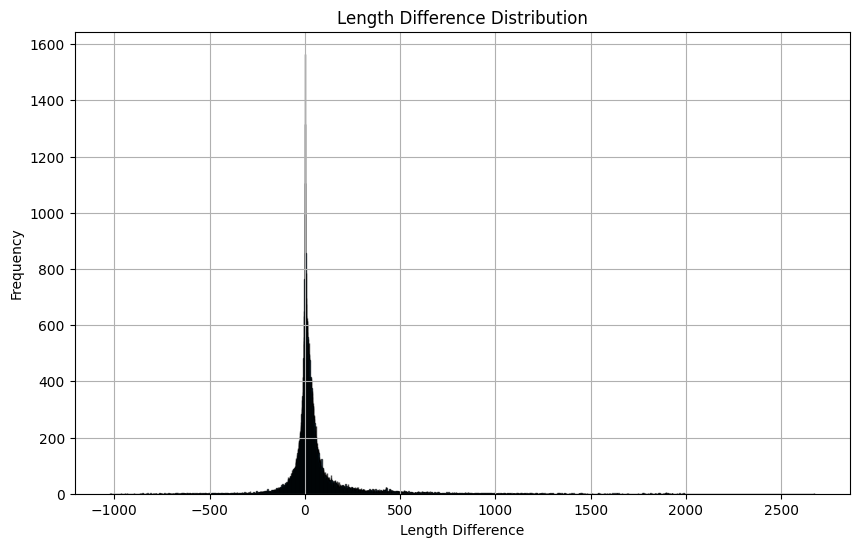

In [6]:
import matplotlib.pyplot as plt  
from collections import Counter  
import numpy as np  
from transformers import AutoTokenizer   
  
# 加载tokenizer  
tokenizer_path = "/mnt/lingjiejiang/textual_aesthetics/model_checkpoint/sft_merge_checkpoints/Meta-Llama-3.1-8B-Instruct"  
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)  
  
# 假设revised_data是你的数据列表  
# revised_data = [{'response': '...', 'revised_text': '...'}, ...]  
# revised_data = [...]  # 这里填入你的实际数据  
  
# 计算长度差异  
length_differences = []  
out_of_range_texts = []  
  
for index, item in enumerate(revised_data):  
    # 对response和revised_text进行分词  
    response_tokens = tokenizer.encode(item['response'])  
    revised_text_tokens = tokenizer.encode(item['revised_text'])  
  
    response_length = len(response_tokens)  
    revised_text_length = len(revised_text_tokens)  
  
    difference = revised_text_length - response_length  
    length_differences.append(difference)  
  
    # 检查是否超出范围  
    if difference < -2048 or difference > 2048:  
        out_of_range_texts.append({  
            'response': item['response'],  
            'revised_text': item['revised_text'],  
            'difference': difference,  
            'index': index  
        })  
  
# 统计分布  
difference_distribution = Counter(length_differences)  
  
# 打印分布结果  
print(difference_distribution)  
  
# 详细统计信息  
differences_array = np.array(length_differences)  
mean = np.mean(differences_array)  
median = np.median(differences_array)  
std_dev = np.std(differences_array)  
  
print(f"Mean: {mean}, Median: {median}, Standard Deviation: {std_dev}")  
  
# 长度差异的最大最小值  
max_difference = max(length_differences)  
min_difference = min(length_differences)  
  
print(f"Max length difference: {max_difference}, Min length difference: {min_difference}")  
  
# 绘制直方图  
plt.figure(figsize=(10, 6))  
plt.hist(length_differences, bins=range(min(length_differences), max(length_differences) + 2), edgecolor='black', alpha=0.7)  
plt.title('Length Difference Distribution')  
plt.xlabel('Length Difference')  
plt.ylabel('Frequency')  
plt.grid(True)  
plt.show()  


In [79]:
len(revised_data)

61135

In [ ]:
def get_length_diff():
    revised_data = read_jsonl('revised_data/output_sorted.jsonl')
    # 加载tokenizer  
    tokenizer_path = "/mnt/lingjiejiang/textual_aesthetics/model_checkpoint/sft_merge_checkpoints/Meta-Llama-3.1-8B-Instruct"  
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, use_fast=True)  
    
    # 假设revised_data是你的数据列表  
    # revised_data = [...]  # 这里填入你的实际数据  
    
    responses = [item['response'] for item in revised_data]  
    revised_texts = [item['revised_text'] for item in revised_data]  
    
    # 批量分词  
    response_tokens_batch = tokenizer(responses, return_tensors="np")  
    revised_text_tokens_batch = tokenizer(revised_texts, return_tensors="np")  
    
    response_lengths = [len(tokens) for tokens in response_tokens_batch["input_ids"]]  
    revised_text_lengths = [len(tokens) for tokens in revised_text_tokens_batch["input_ids"]]  
    return response_lengths, revised_text_lengths
response_lengths, revised_text_lengths = get_length_diff()

In [96]:
from transformers import AutoTokenizer  
from utils import read_jsonl
revised_data = read_jsonl('revised_data/output_sorted.jsonl')
# 加载tokenizer  
tokenizer_path = "/mnt/lingjiejiang/textual_aesthetics/model_checkpoint/sft_merge_checkpoints/Meta-Llama-3.1-8B-Instruct"  
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, use_fast=True)  
  
# 假设revised_data是你的数据列表  
# revised_data = [...]  # 这里填入你的实际数据  
  
responses = [item['response'] for item in revised_data]  
revised_texts = [item['revised_text'] for item in revised_data]  
  
# 批量分词  
response_tokens_batch = tokenizer(responses, return_tensors="np")  
revised_text_tokens_batch = tokenizer(revised_texts, return_tensors="np")  
  
response_lengths = [len(tokens) for tokens in response_tokens_batch["input_ids"]]  
revised_text_lengths = [len(tokens) for tokens in revised_text_tokens_batch["input_ids"]]  
  
# 计算长度差异  
length_differences = []  
out_of_range_texts = []

filtered_revised_data = []
filtered_revised_data_indices = []  

for index, (response_length, revised_text_length) in enumerate(zip(response_lengths, revised_text_lengths)):  
    difference = revised_text_length - response_length  
    length_differences.append(difference)  
  
    # 检查是否超出范围  
    if difference < -88 or difference > 350:  
        out_of_range_texts.append({  
            'response': revised_data[index]['response'],  
            'revised_text': revised_data[index]['revised_text'],  
            'difference': difference,  
            'index': index  
        })  
    # 检查是否在-88及350之间  
    if -88 <= difference <= 350:  
        filtered_revised_data.append(revised_data[index])
        filtered_revised_data_indices.append(revised_data[index]['index']) 

# 统计分布  
difference_distribution = Counter(length_differences)  
  

  
# 详细统计信息  
differences_array = np.array(length_differences)  
mean = np.mean(differences_array)  
median = np.median(differences_array)  
std_dev = np.std(differences_array)  
# 统计分布和绘图代码保持不变  
print(f"Mean: {mean}, Median: {median}, Standard Deviation: {std_dev}")  

# 计算95%置信区间  
lower_bound = np.percentile(differences_array, 5)  
upper_bound = np.percentile(differences_array, 95)  
  
print(f"95% Confidence Interval: [{lower_bound}, {upper_bound}]")  
# 长度差异的最大最小值  
max_difference = max(length_differences)  
min_difference = min(length_differences)  

print(f"Max length difference: {max_difference}, Min length difference: {min_difference}")  
print(f"out_of_range_texts length {len(out_of_range_texts)}")
# # 绘制直方图  
# plt.figure(figsize=(10, 6))  
# plt.hist(length_differences, bins=range(min(length_differences), max(length_differences) + 2), edgecolor='black', alpha=0.7)  
# plt.title('Length Difference Distribution')  
# plt.xlabel('Length Difference')  
# plt.ylabel('Frequency')  
# plt.grid(True)  
# plt.show()  


Mean: 49.15065020037622, Median: 13.0, Standard Deviation: 169.45465111600666
95% Confidence Interval: [-88.0, 342.0]
Max length difference: 2673, Min length difference: -1024
out_of_range_texts length 6008


In [8]:
import matplotlib.pyplot as plt  
from collections import Counter  
import numpy as np  
from transformers import AutoTokenizer 
def get_length_diff():
    revised_data = read_jsonl('revised_data/output_sorted.jsonl')
    # 加载tokenizer  
    tokenizer_path = "/mnt/lingjiejiang/textual_aesthetics/model_checkpoint/sft_merge_checkpoints/Meta-Llama-3.1-8B-Instruct"  
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, use_fast=True)  
    
    # 假设revised_data是你的数据列表  
    # revised_data = [...]  # 这里填入你的实际数据  
    
    responses = [item['response'] for item in revised_data]  
    revised_texts = [item['revised_text'] for item in revised_data]  
    
    # 批量分词  
    response_tokens_batch = tokenizer(responses, return_tensors="np")  
    revised_text_tokens_batch = tokenizer(revised_texts, return_tensors="np")  
    
    response_lengths = [len(tokens) for tokens in response_tokens_batch["input_ids"]]  
    revised_text_lengths = [len(tokens) for tokens in revised_text_tokens_batch["input_ids"]]  
    return response_lengths, revised_text_lengths

def get_filter_data(response_lengths, revised_text_lengths, lower=-88, upper=350):
    revised_data = read_jsonl('revised_data/output_sorted.jsonl')
    # 计算长度差异  
    length_differences = []  
    out_of_range_texts = []
    out_of_range_texts_indices = []
    filtered_revised_data = []
    filtered_revised_data_indices = []  

    for index, (response_length, revised_text_length) in enumerate(zip(response_lengths, revised_text_lengths)):  
        difference = revised_text_length - response_length  
        length_differences.append(difference)  
    
        # 检查是否超出范围  
        if difference < lower or difference > upper:  
            out_of_range_texts.append({  
                'response': revised_data[index]['response'],  
                'revised_text': revised_data[index]['revised_text'],  
                'difference': difference,  
                'index': index  
            })  
            out_of_range_texts_indices.append(revised_data[index]['index'])
        # 检查是否在-88及350之间  
        if lower <= difference and difference <= upper:  
            filtered_revised_data.append(revised_data[index])
            filtered_revised_data_indices.append(revised_data[index]['index']) 

    # 统计分布  
    # difference_distribution = Counter(length_differences)  
        
    # 详细统计信息  
    differences_array = np.array(length_differences)  
    mean = np.mean(differences_array)  
    median = np.median(differences_array)  
    std_dev = np.std(differences_array)  
    # 统计分布和绘图代码保持不变  
    print(f"Mean: {mean}, Median: {median}, Standard Deviation: {std_dev}")  

    # 计算95%置信区间  
    lower_bound = np.percentile(differences_array, 5)  
    upper_bound = np.percentile(differences_array, 95)  
    
    print(f"95% Confidence Interval: [{lower_bound}, {upper_bound}]")  
    # 长度差异的最大最小值  
    max_difference = max(length_differences)  
    min_difference = min(length_differences)  

    print(f"Max length difference: {max_difference}, Min length difference: {min_difference}")  
    print(f"out_of_range_texts length {len(out_of_range_texts)}")
    print(f"filtered_revised_data length {len(filtered_revised_data)}")
    return out_of_range_texts_indices
lower = -88
upper = 350
# out_of_range_texts_indices = get_filter_data(lower, upper)
# response_lengths, revised_text_lengths = get_length_diff()
out_of_range_texts_indices = get_filter_data(response_lengths, revised_text_lengths, lower, upper)
len(out_of_range_texts_indices)

Mean: 49.15065020037622, Median: 13.0, Standard Deviation: 169.45465111600666
95% Confidence Interval: [-88.0, 342.0]
Max length difference: 2673, Min length difference: -1024
out_of_range_texts length 6008
filtered_revised_data length 55127


6008

In [9]:
from datasets import load_dataset, Dataset
import pandas as pd
import json
data = read_jsonl("revised_data/output_sorted.jsonl")
not_revised = [item['index'] for item in data if item['revised_text'] == '']
ds = load_dataset("HuggingFaceH4/ultrafeedback_binarized", split="train_prefs")
def get_instruct_response(item):
    # item["instruction"] = item['chosen'][0]["content"]
    item["response"] = item['chosen'][1]["content"]
    return item
ds = ds.map(get_instruct_response, batch_size=1024, num_proc=8)
export_data = ds.select_columns(["prompt", "response"])
# export_data
# data = filtered_revised_data
not_revised = [item['index'] for item in data if item['revised_text'] == '']
# datalen
# data
indices = set([item['index'] for item in data])
# original_indices = set(range(export_data.shape[0]))
# print(f"index complete: {original_indices - indices}")
null_response_indices = [item['index'] for item in data if item['gpt_answer'].strip() == '']
null_revised_indices = [item['index'] for item in data if item['revised_text'].strip() == '']
noneed_revised_indices = [item['index'] for item in data if item['does_it_need_modification'].strip() == 'N']
same_revised_text_indices = [item['index'] for item in data if item['response'].strip() == item['revised_text'].strip()]

# print(len(null_response))
# print(len(not_revised))
print(f"null_response_indices:{len(null_response_indices)}")
print(f"null_revised_indices:{len(null_revised_indices)}")
print(f"noneed_revised_indices:{len(noneed_revised_indices)}")
print(f"same_revised_text_indices:{len(same_revised_text_indices)}")
# 使用集合的交集操作  
indices_to_discard  = set(null_response_indices) | set(null_revised_indices) | set(noneed_revised_indices) | set(same_revised_text_indices)   
print(f"indices_to_discard: {len(indices_to_discard)}")
# filter length 
indices_to_discard = indices_to_discard | set(out_of_range_texts_indices)
indices_to_discard = list(indices_to_discard)
print(f"indices_to_discard add length: {len(indices_to_discard)}")
temp_data = data
# temp_ds = ds.select(range(10))
for i, item in enumerate(ds):
    # print(item['rejected'])
    # index=item['index']
    temp_data[i]['rejected'] = item['rejected'][1]['content']
    temp_data[i]['instruct'] = item['prompt']
    temp_data[i]['chosen'] = item['chosen']
revised_data = [item for item in temp_data if item["index"] not in indices_to_discard]
print(f"length of revised data: {len(revised_data)}")
textual_aesthetics_chosen = [{"prompt": item["prompt"], "chosen": item["revised_text"], "rejected": item["response"]} for item in revised_data]
with open(f"/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_chosen_v3_{lower}_{upper}.json", 'w') as f:
    json.dump(textual_aesthetics_chosen, f, indent=4)
textual_aesthetics_rejected = [{"prompt": item["prompt"], "chosen": item["revised_text"], "rejected": item["rejected"]} for item in revised_data]
textual_aesthetics_rejected.extend([{"prompt": item["prompt"], "chosen": item["response"], "rejected": item["rejected"]} for item in temp_data if item["index"] in indices_to_discard])  
with open(f"/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_rejected_v4_{lower}_{upper}_add_uf.json", 'w') as f:
    json.dump(textual_aesthetics_rejected, f, indent=4)
print(f"textual_aesthetics_chosen:{len(textual_aesthetics_chosen)}  textual_aesthetics_rejected:{len(textual_aesthetics_rejected)}")

null_response_indices:136
null_revised_indices:5525
noneed_revised_indices:5524
same_revised_text_indices:335
indices_to_discard: 5858
indices_to_discard add length: 10745
length of revised data: 50390
textual_aesthetics_chosen:50390  textual_aesthetics_rejected:61135


In [ ]:
from datasets import load_dataset, Dataset
import pandas as pd
import json
data = read_jsonl("revised_data/output_sorted.jsonl")
not_revised = [item['index'] for item in data if item['revised_text'] == '']
ds = load_dataset("HuggingFaceH4/ultrafeedback_binarized", split="train_prefs")
def get_instruct_response(item):
    # item["instruction"] = item['chosen'][0]["content"]
    item["response"] = item['chosen'][1]["content"]
    return item
ds = ds.map(get_instruct_response, batch_size=1024, num_proc=8)
export_data = ds.select_columns(["prompt", "response"])
# export_data
# data = filtered_revised_data
not_revised = [item['index'] for item in data if item['revised_text'] == '']
# datalen
# data
indices = set([item['index'] for item in data])
# original_indices = set(range(export_data.shape[0]))
# print(f"index complete: {original_indices - indices}")
null_response_indices = [item['index'] for item in data if item['gpt_answer'].strip() == '']
null_revised_indices = [item['index'] for item in data if item['revised_text'].strip() == '']
noneed_revised_indices = [item['index'] for item in data if item['does_it_need_modification'].strip() == 'N']
same_revised_text_indices = [item['index'] for item in data if item['response'].strip() == item['revised_text'].strip()]

# print(len(null_response))
# print(len(not_revised))
print(f"null_response_indices:{len(null_response_indices)}")
print(f"null_revised_indices:{len(null_revised_indices)}")
print(f"noneed_revised_indices:{len(noneed_revised_indices)}")
print(f"same_revised_text_indices:{len(same_revised_text_indices)}")
# 使用集合的交集操作  
indices_to_discard  = set(null_response_indices) | set(null_revised_indices) | set(noneed_revised_indices) | set(same_revised_text_indices)   
print(f"indices_to_discard: {len(indices_to_discard)}")
# filter length 
indices_to_discard = indices_to_discard | set(out_of_range_texts_indices)
indices_to_discard = list(indices_to_discard)
print(f"indices_to_discard add length: {len(indices_to_discard)}")
temp_data = data
# temp_ds = ds.select(range(10))
for i, item in enumerate(ds):
    # print(item['rejected'])
    # index=item['index']
    temp_data[i]['rejected'] = item['rejected'][1]['content']
    temp_data[i]['instruct'] = item['prompt']
    temp_data[i]['chosen'] = item['chosen']
revised_data = [item for item in temp_data if item["index"] not in indices_to_discard]
print(f"length of revised data: {len(revised_data)}")
textual_aesthetics_chosen = [{"prompt": item["prompt"], "chosen": item["revised_text"], "rejected": item["response"]} for item in revised_data]
# with open("/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_chosen_v4_{lower}_{upper}.json", 'w') as f:
#     json.dump(textual_aesthetics_chosen, f, indent=4)
textual_aesthetics_rejected = [{"prompt": item["prompt"], "chosen": item["revised_text"], "rejected": item["rejected"]} for item in revised_data]
with open(f"/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_rejected_v4_{lower}_{upper}.json", 'w') as f:
    json.dump(textual_aesthetics_rejected, f, indent=4)
print(f"textual_aesthetics_chosen:{len(textual_aesthetics_chosen)}  textual_aesthetics_rejected:{len(textual_aesthetics_rejected)}")

Counter({0: 1566, -1: 1316, 1: 1107, 2: 995, 3: 858, 4: 784, -2: 764, 5: 697, 6: 676, -6: 650, 7: 634, -3: 631, 10: 625, 9: 616, 8: 613, 12: 605, 11: 576, 13: 559, -7: 558, 18: 550, -4: 543, 15: 537, 20: 537, -5: 533, 14: 530, 16: 507, 19: 499, 21: 494, -8: 482, 17: 482, 23: 482, 24: 477, 22: 440, 29: 417, -10: 415, 25: 415, 27: 414, -9: 414, 30: 413, 26: 408, 31: 403, 28: 400, 34: 378, 33: 375, 32: 373, 39: 364, -12: 362, 35: 359, -13: 348, 36: 345, -11: 345, -15: 334, 37: 329, 42: 324, 38: 318, 40: 313, 43: 313, -14: 307, 44: 305, -16: 303, -17: 291, -18: 284, 48: 281, 41: 281, 46: 275, 45: 266, -20: 254, 50: 251, -19: 244, 47: 243, 56: 241, 51: 241, -21: 238, -22: 229, 54: 226, -24: 224, 49: 224, -23: 215, 53: 212, -25: 207, -26: 202, 55: 201, 52: 201, -30: 191, -29: 189, 60: 189, -33: 184, -27: 184, -28: 183, 57: 182, 62: 181, -32: 181, 58: 176, -31: 175, 63: 167, 59: 165, 61: 165, -35: 162, 70: 160, -36: 158, 67: 158, -34: 157, 69: 153, 68: 152, 65: 149, 64: 148, 66: 148, 71: 145,

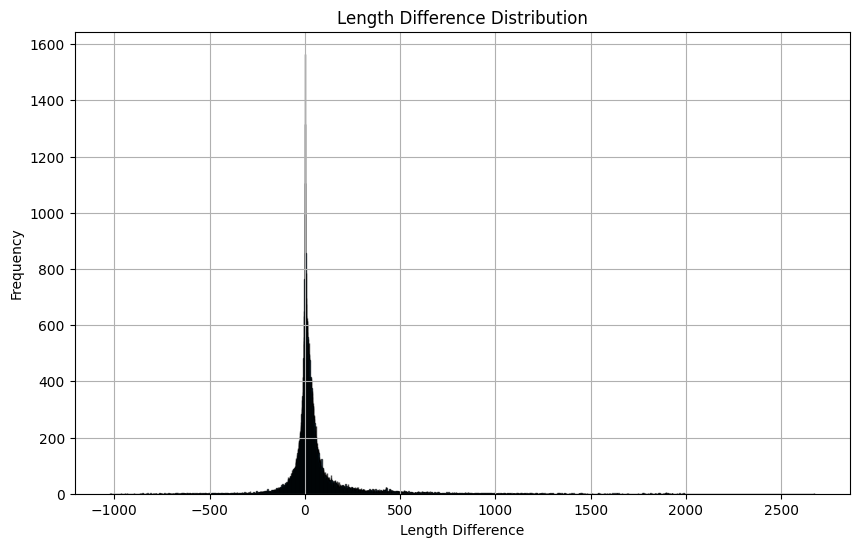

In [24]:
# 计算长度差异  
length_differences = []  
out_of_range_texts = []  
# 计算长度差异并过滤数据  
filtered_revised_data = []  
for index, (response_length, revised_text_length) in enumerate(zip(response_lengths, revised_text_lengths)):  
    difference = revised_text_length - response_length  
    length_differences.append(difference)  
  
    # 检查是否超出范围  
    if difference < -88 or difference > 500:  
        out_of_range_texts.append({  
            'response': revised_data[index]['response'],  
            'revised_text': revised_data[index]['revised_text'],  
            'difference': difference,  
            'index': index  
        })  
    # 检查是否在-88及350之间  
    if -88 <= difference <= 350:  
        filtered_revised_data.append(revised_data[index]) 

# 统计分布  
difference_distribution = Counter(length_differences)  
  
# 打印分布结果  
print(difference_distribution)  
  
# 详细统计信息  
differences_array = np.array(length_differences)  
mean = np.mean(differences_array)  
median = np.median(differences_array)  
std_dev = np.std(differences_array)  
# 统计分布和绘图代码保持不变  
print(f"Mean: {mean}, Median: {median}, Standard Deviation: {std_dev}")  

# 计算95%置信区间  
lower_bound = np.percentile(differences_array, 2.5)  
upper_bound = np.percentile(differences_array, 95)  
  
print(f"90% Confidence Interval: [{lower_bound}, {upper_bound}]")  
# 长度差异的最大最小值  
max_difference = max(length_differences)  
min_difference = min(length_differences)  

print(f"Max length difference: {max_difference}, Min length difference: {min_difference}")  
print(f"out_of_range_texts length {len(out_of_range_texts)}")
# 绘制直方图  
plt.figure(figsize=(10, 6))  
plt.hist(length_differences, bins=range(min(length_differences), max(length_differences) + 2), edgecolor='black', alpha=0.7)  
plt.title('Length Difference Distribution')  
plt.xlabel('Length Difference')  
plt.ylabel('Frequency')  
plt.grid(True)  
plt.show()  

In [1]:
from datasets import load_dataset, Dataset
import pandas as pd
ds = load_dataset("HuggingFaceH4/ultrafeedback_binarized", split="train_prefs")
def get_instruct_response(item):
    # item["instruction"] = item['chosen'][0]["content"]
    item["response"] = item['chosen'][1]["content"]
    return item
ds = ds.map(get_instruct_response, batch_size=1024, num_proc=8)
export_data = ds.select_columns(["prompt", "response"])
from utils import read_jsonl
import json 
data = read_jsonl("revised_data/output_sorted_v2.jsonl")
not_revised = [item['index'] for item in data if item['revised_text'] == '']
indices = set([item['index'] for item in data])
original_indices = set(range(export_data.shape[0]))
print(f"index complete: {original_indices - indices}")
null_response_indices = [item['index'] for item in data if item['gpt_answer'].strip() == '']
null_revised_indices = [item['index'] for item in data if item['revised_text'].strip() == '']
noneed_revised_indices = [item['index'] for item in data if item['does_it_need_modification'].strip() == 'N']
same_revised_text_indices = [item['index'] for item in data if item['response'].strip() == item['revised_text'].strip()]

print(f"null_response_indices:{len(null_response_indices)}")
print(f"null_revised_indices:{len(null_revised_indices)}")
print(f"noneed_revised_indices:{len(noneed_revised_indices)}")
print(f"same_revised_text_indices:{len(same_revised_text_indices)}")
# 使用集合的交集操作  
indices_to_discard  = set(null_response_indices) | set(null_revised_indices) | set(noneed_revised_indices) | set(same_revised_text_indices)    
indices_to_discard = list(indices_to_discard)
print(f"indices_to_discard: {len(indices_to_discard)}")
temp_data = data

for i, item in enumerate(ds):

    temp_data[i]['rejected'] = item['rejected'][1]['content']
    temp_data[i]['instruct'] = item['prompt']
    temp_data[i]['chosen'] = item['chosen']
revised_data = [item for item in temp_data if item["index"] not in indices_to_discard]
print(f"length of revised data: {len(revised_data)}")
textual_aesthetics_chosen = [{"prompt": item["prompt"], "chosen": item["revised_text"], "rejected": item["response"]} for item in revised_data]
with open("/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_chosen_v2.json", 'w') as f:
    json.dump(textual_aesthetics_chosen, f, indent=4)
textual_aesthetics_rejected = [{"prompt": item["prompt"], "chosen": item["revised_text"], "rejected": item["rejected"]} for item in revised_data]
with open("/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_rejected_v2.json", 'w') as f:
    json.dump(textual_aesthetics_rejected, f, indent=4)

/home/lidong1/miniconda3/envs/llama_factory/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


index complete: set()
null_response_indices:110
null_revised_indices:6816
noneed_revised_indices:6815
same_revised_text_indices:324
indices_to_discard: 7138
length of revised data: 53997


In [22]:
from transformers import AutoTokenizer 
import matplotlib.pyplot as plt  
from collections import Counter  
import numpy as np  
from transformers import AutoTokenizer   
def get_length_diff():
    revised_data = read_jsonl('revised_data/output_sorted_v2.jsonl')
    # 加载tokenizer  
    tokenizer_path = "/mnt/lingjiejiang/textual_aesthetics/model_checkpoint/sft_merge_checkpoints/Meta-Llama-3.1-8B-Instruct"  
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, use_fast=True)  
    
    # 假设revised_data是你的数据列表  
    # revised_data = [...]  # 这里填入你的实际数据  
    
    responses = [item['response'] for item in revised_data]  
    revised_texts = [item['revised_text'] for item in revised_data]  
    
    # 批量分词  
    response_tokens_batch = tokenizer(responses, return_tensors="np")  
    revised_text_tokens_batch = tokenizer(revised_texts, return_tensors="np")  
    
    response_lengths = [len(tokens) for tokens in response_tokens_batch["input_ids"]]  
    revised_text_lengths = [len(tokens) for tokens in revised_text_tokens_batch["input_ids"]]  
    return response_lengths, revised_text_lengths

def get_filter_data(response_lengths, revised_text_lengths, lower=-88, upper=350):
    revised_data = read_jsonl('revised_data/output_sorted_v2.jsonl')
    # 计算长度差异  
    length_differences = []  
    out_of_range_texts = []
    out_of_range_texts_indices = []
    filtered_revised_data = []
    filtered_revised_data_indices = []  

    for index, (response_length, revised_text_length) in enumerate(zip(response_lengths, revised_text_lengths)):  
        difference = revised_text_length - response_length  
        length_differences.append(difference)  
    
        # 检查是否超出范围  
        if difference < lower or difference > upper:  
            out_of_range_texts.append({  
                'response': revised_data[index]['response'],  
                'revised_text': revised_data[index]['revised_text'],  
                'difference': difference,  
                'index': index  
            })  
            out_of_range_texts_indices.append(revised_data[index]['index'])
        # 检查是否在-88及350之间  
        if lower <= difference and difference <= upper:  
            filtered_revised_data.append(revised_data[index])
            filtered_revised_data_indices.append(revised_data[index]['index']) 

    # 统计分布  
    # difference_distribution = Counter(length_differences)  
    

    
    # 详细统计信息  
    differences_array = np.array(length_differences)  
    mean = np.mean(differences_array)  
    median = np.median(differences_array)  
    std_dev = np.std(differences_array)  
    # 统计分布和绘图代码保持不变  
    print(f"Mean: {mean}, Median: {median}, Standard Deviation: {std_dev}")  

    # 计算95%置信区间  
    lower_bound = np.percentile(differences_array, 5)  
    upper_bound = np.percentile(differences_array, 95)  
    
    print(f"95% Confidence Interval: [{lower_bound}, {upper_bound}]")  
    # 长度差异的最大最小值  
    max_difference = max(length_differences)  
    min_difference = min(length_differences)  

    print(f"Max length difference: {max_difference}, Min length difference: {min_difference}")  
    print(f"out_of_range_texts length {len(out_of_range_texts)}")
    print(f"filtered_revised_data length {len(filtered_revised_data)}")
    return out_of_range_texts_indices
lower = -118
upper = 350
# out_of_range_texts_indices = get_filter_data(lower, upper)
# response_lengths, revised_text_lengths = get_length_diff()
out_of_range_texts_indices = get_filter_data(response_lengths, revised_text_lengths, lower, upper)
len(out_of_range_texts_indices)

Mean: 32.17423734358387, Median: 4.0, Standard Deviation: 166.34642309858634
95% Confidence Interval: [-118.0, 290.0]
Max length difference: 3639, Min length difference: -1024
out_of_range_texts length 5451
filtered_revised_data length 55684


5451

In [20]:
from datasets import load_dataset, Dataset
import pandas as pd
import json
data = read_jsonl("revised_data/output_sorted_v2.jsonl")
not_revised = [item['index'] for item in data if item['revised_text'] == '']
ds = load_dataset("HuggingFaceH4/ultrafeedback_binarized", split="train_prefs")
def get_instruct_response(item):
    # item["instruction"] = item['chosen'][0]["content"]
    item["response"] = item['chosen'][1]["content"]
    return item
ds = ds.map(get_instruct_response, batch_size=1024, num_proc=8)
export_data = ds.select_columns(["prompt", "response"])

not_revised = [item['index'] for item in data if item['revised_text'] == '']
# datalen
# data
indices = set([item['index'] for item in data])
# original_indices = set(range(export_data.shape[0]))
# print(f"index complete: {original_indices - indices}")
null_response_indices = [item['index'] for item in data if item['gpt_answer'].strip() == '']
null_revised_indices = [item['index'] for item in data if item['revised_text'].strip() == '']
noneed_revised_indices = [item['index'] for item in data if item['does_it_need_modification'].strip() == 'N']
same_revised_text_indices = [item['index'] for item in data if item['response'].strip() == item['revised_text'].strip()]

# print(len(null_response))
# print(len(not_revised))
print(f"null_response_indices:{len(null_response_indices)}")
print(f"null_revised_indices:{len(null_revised_indices)}")
print(f"noneed_revised_indices:{len(noneed_revised_indices)}")
print(f"same_revised_text_indices:{len(same_revised_text_indices)}")
# 使用集合的交集操作  
indices_to_discard  = set(null_response_indices) | set(null_revised_indices) | set(noneed_revised_indices) | set(same_revised_text_indices)   
print(f"indices_to_discard: {len(indices_to_discard)}")
# filter length 
indices_to_discard = indices_to_discard | set(out_of_range_texts_indices)
indices_to_discard = list(indices_to_discard)
print(f"indices_to_discard add length: {len(indices_to_discard)}")
temp_data = data
# temp_ds = ds.select(range(10))
for i, item in enumerate(ds):
    temp_data[i]['rejected'] = item['rejected'][1]['content']
    temp_data[i]['instruct'] = item['prompt']
    temp_data[i]['chosen'] = item['chosen']
revised_data = [item for item in temp_data if item["index"] not in indices_to_discard]
print(f"length of revised data: {len(revised_data)}")
textual_aesthetics_chosen = [{"prompt": item["prompt"], "chosen": item["revised_text"], "rejected": item["response"]} for item in revised_data]
# with open("/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_chosen_v4_{lower}_{upper}.json", 'w') as f:
#     json.dump(textual_aesthetics_chosen, f, indent=4)
textual_aesthetics_rejected = [{"prompt": item["prompt"], "chosen": item["revised_text"], "rejected": item["rejected"]} for item in revised_data]
with open(f"/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_v2_rejected_v3_{lower}_{upper}.json", 'w') as f:
    json.dump(textual_aesthetics_rejected, f, indent=4)
print(f"/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_v2_rejected_v3_{lower}_{upper}.json")
print(f"textual_aesthetics_chosen:{len(textual_aesthetics_chosen)}  textual_aesthetics_rejected:{len(textual_aesthetics_rejected)}")

null_response_indices:110
null_revised_indices:6816
noneed_revised_indices:6815
same_revised_text_indices:324
indices_to_discard: 7138
indices_to_discard add length: 13212
length of revised data: 47923
/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_v2_rejected_v3_-80_350.json
textual_aesthetics_chosen:47923  textual_aesthetics_rejected:47923


In [21]:
# from datasets import load_dataset, Dataset
# import pandas as pd
# import json
# data = read_jsonl("revised_data/output_sorted_v2.jsonl")
# not_revised = [item['index'] for item in data if item['revised_text'] == '']
# ds = load_dataset("HuggingFaceH4/ultrafeedback_binarized", split="train_prefs")
# def get_instruct_response(item):
#     # item["instruction"] = item['chosen'][0]["content"]
#     item["response"] = item['chosen'][1]["content"]
#     return item
# ds = ds.map(get_instruct_response, batch_size=1024, num_proc=8)
# export_data = ds.select_columns(["prompt", "response"])

# not_revised = [item['index'] for item in data if item['revised_text'] == '']
# # datalen
# # data
# indices = set([item['index'] for item in data])
# # original_indices = set(range(export_data.shape[0]))
# # print(f"index complete: {original_indices - indices}")
# null_response_indices = [item['index'] for item in data if item['gpt_answer'].strip() == '']
# null_revised_indices = [item['index'] for item in data if item['revised_text'].strip() == '']
# noneed_revised_indices = [item['index'] for item in data if item['does_it_need_modification'].strip() == 'N']
# same_revised_text_indices = [item['index'] for item in data if item['response'].strip() == item['revised_text'].strip()]

# # print(len(null_response))
# # print(len(not_revised))
# print(f"null_response_indices:{len(null_response_indices)}")
# print(f"null_revised_indices:{len(null_revised_indices)}")
# print(f"noneed_revised_indices:{len(noneed_revised_indices)}")
# print(f"same_revised_text_indices:{len(same_revised_text_indices)}")
# # 使用集合的交集操作  
# indices_to_discard  = set(null_response_indices) | set(null_revised_indices) | set(noneed_revised_indices) | set(same_revised_text_indices)   
# print(f"indices_to_discard: {len(indices_to_discard)}")
# # filter length 
# indices_to_discard = indices_to_discard | set(out_of_range_texts_indices)
# indices_to_discard = list(indices_to_discard)
# print(f"indices_to_discard add length: {len(indices_to_discard)}")
# temp_data = data
# # temp_ds = ds.select(range(10))
# for i, item in enumerate(ds):
#     temp_data[i]['rejected'] = item['rejected'][1]['content']
#     temp_data[i]['instruct'] = item['prompt']
#     temp_data[i]['chosen'] = item['chosen']
# revised_data = [item for item in temp_data if item["index"] not in indices_to_discard]
# print(f"length of revised data: {len(revised_data)}")
# textual_aesthetics_chosen = [{"prompt": item["prompt"], "chosen": item["revised_text"], "rejected": item["response"]} for item in revised_data]
# # with open("/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_chosen_v4_{lower}_{upper}.json", 'w') as f:
# #     json.dump(textual_aesthetics_chosen, f, indent=4)
# textual_aesthetics_rejected = [{"prompt": item["prompt"], "chosen": item["revised_text"], "rejected": item["rejected"]} for item in revised_data]
# with open(f"/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_v2_rejected_v2_{lower}_{upper}.json", 'w') as f:
#     json.dump(textual_aesthetics_rejected, f, indent=4)
# print(f"/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_v2_rejected_v2_{lower}_{upper}.json")
# print(f"textual_aesthetics_chosen:{len(textual_aesthetics_chosen)}  textual_aesthetics_rejected:{len(textual_aesthetics_rejected)}")

In [25]:
from datasets import load_dataset, Dataset  
import pandas as pd  
import json  
  
def read_jsonl(file_path):  
    with open(file_path, 'r') as file:  
        data = [json.loads(line) for line in file]  
    return data  
  
# Load data from JSONL file  
data = read_jsonl("revised_data/output_sorted_v2.jsonl")  
  
# Initialize indices to discard  
not_revised = [item['index'] for item in data if item['revised_text'] == '']  
  
# Load dataset  
ds = load_dataset("HuggingFaceH4/ultrafeedback_binarized", split="train_prefs")  
  
# Function to get response from instruction  
def get_instruct_response(item):  
    item["response"] = item['chosen'][1]["content"]  
    return item  
  
# Map function to dataset  
ds = ds.map(get_instruct_response, batch_size=1024, num_proc=8)  
  
# Select relevant columns  
export_data = ds.select_columns(["prompt", "response"])  
  
# Various indices based on different conditions  
null_response_indices = [item['index'] for item in data if item['gpt_answer'].strip() == '']  
null_revised_indices = [item['index'] for item in data if item['revised_text'].strip() == '']  
noneed_revised_indices = [item['index'] for item in data if item['does_it_need_modification'].strip() == 'N']  
same_revised_text_indices = [item['index'] for item in data if item['response'].strip() == item['revised_text'].strip()]  
  
# Print lengths of various conditions  
print(f"null_response_indices: {len(null_response_indices)}")  
print(f"null_revised_indices: {len(null_revised_indices)}")  
print(f"noneed_revised_indices: {len(noneed_revised_indices)}")  
print(f"same_revised_text_indices: {len(same_revised_text_indices)}")  
  
# Combine indices to discard  
indices_to_discard  = set(null_response_indices) | set(null_revised_indices) | set(noneed_revised_indices) | set(same_revised_text_indices)  
print(f"indices_to_discard: {len(indices_to_discard)}")  
  
# Convert indices to list  
indices_to_discard = indices_to_discard | set(out_of_range_texts_indices)
indices_to_discard = list(indices_to_discard)  
print(f"indices_to_discard add length: {len(indices_to_discard)}")  
  
# Initialize temporary data  
temp_data = data  
  
# Update temp_data with additional fields  
for i, item in enumerate(ds):  
    temp_data[i]['rejected'] = item['rejected'][1]['content']  
    temp_data[i]['instruct'] = item['prompt']  
    temp_data[i]['chosen'] = item['chosen']  
  
# Filter revised data  
revised_data = [item for item in temp_data if item["index"] not in indices_to_discard]  
print(f"length of revised data: {len(revised_data)}")  
  
# Prepare textual aesthetics chosen data  
textual_aesthetics_chosen = [{"prompt": item["prompt"], "chosen": item["revised_text"], "rejected": item["response"]} for item in revised_data]  
  
# Prepare textual aesthetics rejected data including indices_to_discard items  
textual_aesthetics_rejected = [{"prompt": item["prompt"], "chosen": item["revised_text"], "rejected": item["rejected"]} for item in revised_data]  
textual_aesthetics_rejected.extend([{"prompt": item["prompt"], "chosen": item["response"], "rejected": item["rejected"]} for item in temp_data if item["index"] in indices_to_discard])  
  
# # Save textual aesthetics rejected data to JSON file  
with open(f"/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_v2_rejected_v4_{lower}_{upper}_add_uf_origin.json", 'w') as f:  
    json.dump(textual_aesthetics_rejected, f, indent=4)  
  
# Print file path and counts  
print(f"/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_v2_rejected_v4_{lower}_{upper}_add_uf_origin.json")  
print(f"textual_aesthetics_chosen: {len(textual_aesthetics_chosen)}  textual_aesthetics_rejected: {len(textual_aesthetics_rejected)}")  


null_response_indices: 110
null_revised_indices: 6816
noneed_revised_indices: 6815
same_revised_text_indices: 324
indices_to_discard: 7138
indices_to_discard add length: 11509
length of revised data: 49626
/mnt/lingjiejiang/textual_aesthetics/data/textual_aesthetics_v2_rejected_v4_-118_350_add_uf_origin.json
textual_aesthetics_chosen: 49626  textual_aesthetics_rejected: 61135
